# Machine Learning

## Notebook #3: Model 2
*This is the 3rd notebook of 3 notebooks for the WiDS Datathon 2024 Challenge #1 Kaggle challenge that ran from 1/9/2024 to 3/1/2024.*

Challenge page link: https://www.kaggle.com/competitions/widsdatathon2024-challenge1/overview . 

Below is my process and breakdown for Model 2. I tried to make Model 2 as seamless as I could so it would be easy for benchmarking.

### Train ML Algorithm

In [1]:
# import libraries and packages. Load train and test datasets
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
#import optuna
from sklearn.linear_model import SGDClassifier
from IPython.display import HTML, display
import tabulate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Training set
pdf = pd.read_csv('pandas-train.csv')
sdf = pd.read_csv('scikitlearn-train.csv')

# Test set
ptdf = pd.read_csv('pandas-test.csv')
stdf = pd.read_csv('scikitlearn-test.csv')

# Submission set
submission = pd.read_csv('sample_submission.csv')

#### Training, Test Splits, and Scaling

*For Notebook 3, I just cleaned it up for running every cell sequentially as you go down through the notebook. This is to clear any confusion from Notebook #2.*

In [3]:
# Pandas training and test sets
x_train = pdf.drop('DiagPeriodL90D', axis=1)
y_train = pdf['DiagPeriodL90D']
x_test = ptdf

# Sci-kit Learn training and test sets
x_train2 = sdf.drop('DiagPeriodL90D', axis=1)
y_train2 = sdf['DiagPeriodL90D']
x_test2 = stdf

*Dimensions are off. Training and Test sets were not properly preprocessed for training and testing. Data shapes are not uniform.*

In [4]:
x_test2.shape, x_train2.shape, y_train2.shape

((5792, 277), (12906, 296), (12906,))

In [5]:
x_train.shape[1], x_train2.shape[1]

(278, 296)

In [6]:
x_test.shape[1], x_test2.shape[1]

(259, 277)

In [7]:
# The column dimensions between training and test sets had to match.
x_train, x_test = x_train.align(x_test, join='outer', axis=1, fill_value=0)
x_train2, x_test2 = x_train2.align(x_test2, join='outer', axis=1, fill_value=0)

In [8]:
x_test2.shape, x_train2.shape, y_train2.shape

((5792, 300), (12906, 300), (12906,))

In [9]:
x_train.shape[1], x_test.shape[1]

(282, 282)

In [10]:
x_train2.shape[1], x_test2.shape[1]

(300, 300)

In [11]:
# Scaling training and test sets
scaler = StandardScaler()

# Apply transform to both the training set and the test set.

# Pandas one-hot encoded training and test sets
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Sci-kit Learn's one-hot encoded training and test sets
x_train2 = scaler.fit_transform(x_train2)
x_test2 = scaler.transform(x_test2)

### Evaluation Performance and Metrics

#### ROC Curves and AUC

In [12]:
def compare_classifiers(classifiers, x_train, y_train, **kwargs):
    plt.figure(figsize=(8, 6))

    for clf_name, clf in classifiers.items():
        if hasattr(clf, "predict_proba"):
            y_train_scores = cross_val_predict(clf, x_train, y_train, cv=5, method='predict_proba')[:, 1]
        elif hasattr(clf, "decision_function"):
            y_train_scores = cross_val_predict(clf, x_train, y_train, cv=5, method='decision_function')
        else:
            raise RuntimeError(f"{clf_name} has neither a predict_proba method nor a decision_function method.")

        fpr, tpr, _ = roc_curve(y_train, y_train_scores)
        auc_score = roc_auc_score(y_train, y_train_scores)
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_score:.4f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

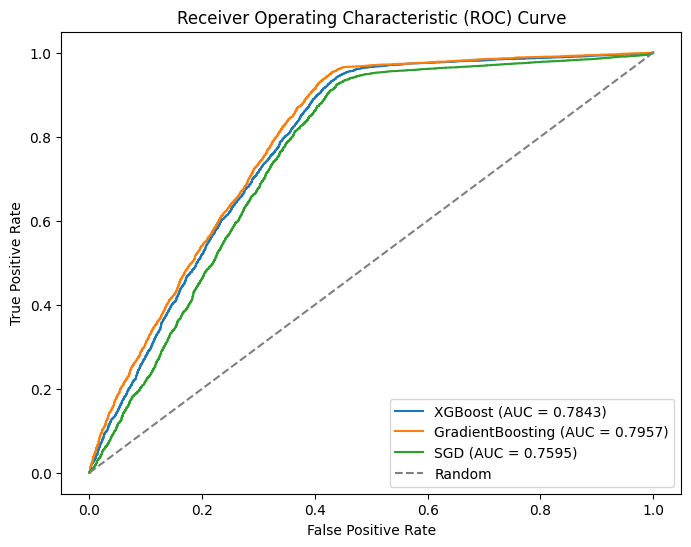

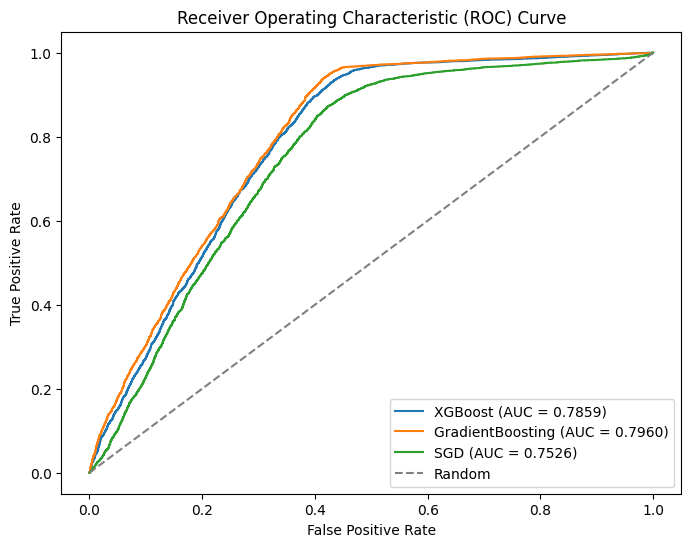

In [13]:
# Define model classifiers
classifiers = {
    'XGBoost': XGBClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SGD': SGDClassifier()
}

# Perform model comparisons
compare_classifiers(classifiers, x_train, y_train)
compare_classifiers(classifiers, x_train2, y_train2)

#### Cross-validation Accuracy

In [15]:
# Define model classifiers
classifiers = {
    'XGBoost': XGBClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SGD': SGDClassifier()
}
print('Pandas training set:')
for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print(f"{clf_name} model cross-validation accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.2f})")

print()

print('Scikit-Learn training set:')
for clf_name, clf in classifiers.items():
    scores2 = cross_val_score(clf, x_train2, y_train2, cv=5, scoring='accuracy')
    print(f"{clf_name} model cross-validation accuracy: {scores2.mean():.4f} (+/- {scores2.std() * 2:.2f})")

Pandas training set:
XGBoost model cross-validation accuracy: 0.7938 (+/- 0.01)
GradientBoosting model cross-validation accuracy: 0.8095 (+/- 0.02)
SGD model cross-validation accuracy: 0.7693 (+/- 0.01)

Scikit-Learn training set:
XGBoost model cross-validation accuracy: 0.7925 (+/- 0.01)
GradientBoosting model cross-validation accuracy: 0.8095 (+/- 0.02)
SGD model cross-validation accuracy: 0.7706 (+/- 0.02)


#### XGBoost Model: Log Loss

[0]	train-logloss:0.57103
[1]	train-logloss:0.52746
[2]	train-logloss:0.50124
[3]	train-logloss:0.48492
[4]	train-logloss:0.47339
[5]	train-logloss:0.46513
[6]	train-logloss:0.45603
[7]	train-logloss:0.45102
[8]	train-logloss:0.44607
[9]	train-logloss:0.44060
[10]	train-logloss:0.43731
[11]	train-logloss:0.43555
[12]	train-logloss:0.43198
[13]	train-logloss:0.43000
[14]	train-logloss:0.42609
[15]	train-logloss:0.42421
[16]	train-logloss:0.42151
[17]	train-logloss:0.41898
[18]	train-logloss:0.41647
[19]	train-logloss:0.41239
[20]	train-logloss:0.40768
[21]	train-logloss:0.40567
[22]	train-logloss:0.40203
[23]	train-logloss:0.40102
[24]	train-logloss:0.39966
[25]	train-logloss:0.39849
[26]	train-logloss:0.39783
[27]	train-logloss:0.39623
[28]	train-logloss:0.39209
[29]	train-logloss:0.38787
[30]	train-logloss:0.38567
[31]	train-logloss:0.38520
[32]	train-logloss:0.38369
[33]	train-logloss:0.38063
[34]	train-logloss:0.37713
[35]	train-logloss:0.37588
[36]	train-logloss:0.37347
[37]	train-

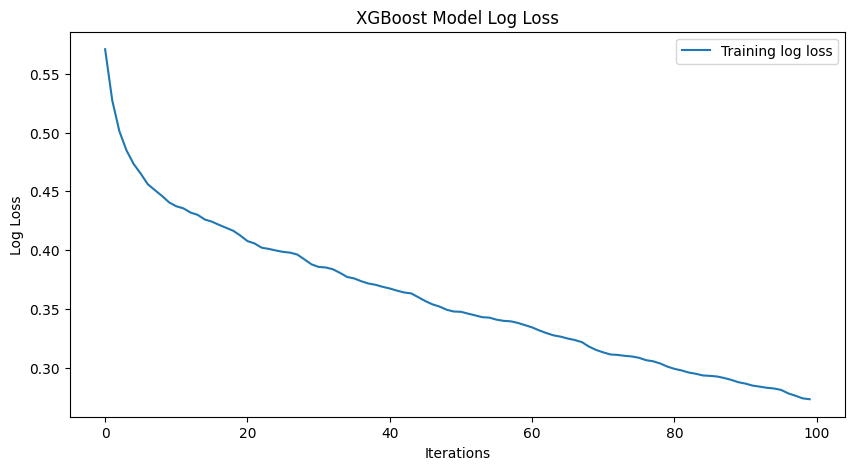

In [16]:
D_train = xgb.DMatrix(x_train, label=y_train)

# Model parameters
params = {
      'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'eval_metric': 'logloss'
}

# Placeholder for evals_result
evals_result = {}

# Train the model
model = xgb.train(params, D_train, num_boost_round=100, evals=[(D_train, 'train')], evals_result=evals_result)

# Get the training errors
train_errors = evals_result['train']['logloss']

# Plot the training curve
plt.figure(figsize=(10, 5))
plt.title('XGBoost Model Log Loss')
plt.plot(train_errors, label='Training log loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [17]:
def plot_learning_curve(model, x_train, y_train, cv=5, scoring='accuracy'):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, x_train, y_train, cv=cv, n_jobs=-1, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid()
    plt.show()

Gradient Boosting Model


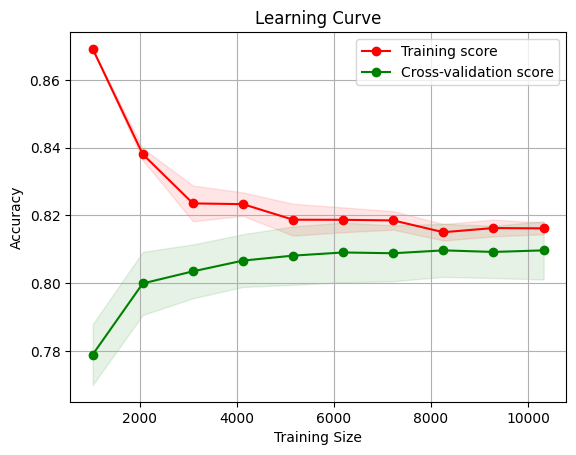

XGBoost Model


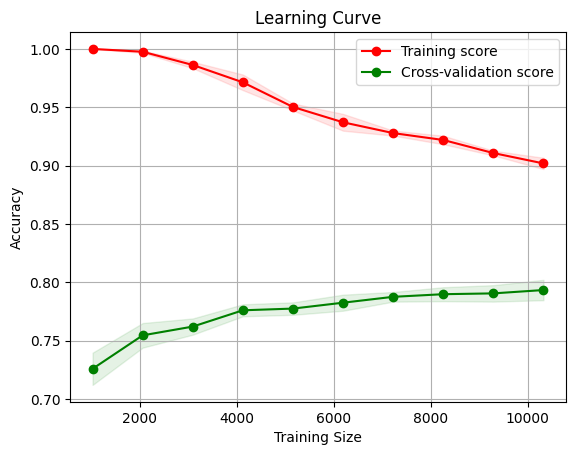

Stochastic Gradient Descent Model


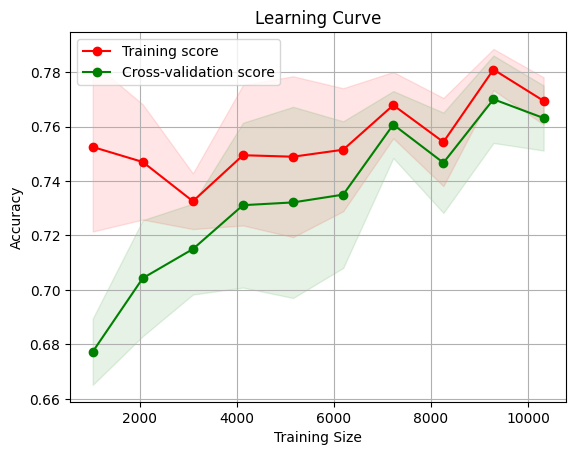

In [18]:
# Initialize the models
gb_model = GradientBoostingClassifier()
xgb_model = XGBClassifier()
sgd_model = SGDClassifier()

# Plot learning curves for each model
print('Gradient Boosting Model')
plot_learning_curve(gb_model, x_train2, y_train2)
print('XGBoost Model')
plot_learning_curve(xgb_model, x_train2, y_train2)
print('Stochastic Gradient Descent Model')
plot_learning_curve(sgd_model, x_train2, y_train2)

#### Hyper-parameter Tuning

#### GridSearchCV

*Note: Fine-tuning the Gradient Boosting model was taking over 3 hours on my machine. Try 1 or 2 parameters first at a time.*

In [19]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    #'subsample': [0.5, 0.7, 1.0],
    #'min_samples_split': [2, 4, 6],
    #'min_samples_leaf': [1, 2, 3],
    #'max_depth': [3, 5, 7],
    #'max_features': ['sqrt', 'log2', None]
    # you can add more parameters here or shorten the list.
}

clf = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fitting model
grid_search.fit(x_train2, y_train2)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

Accuracy: 0.8101 (+/- 0.02)



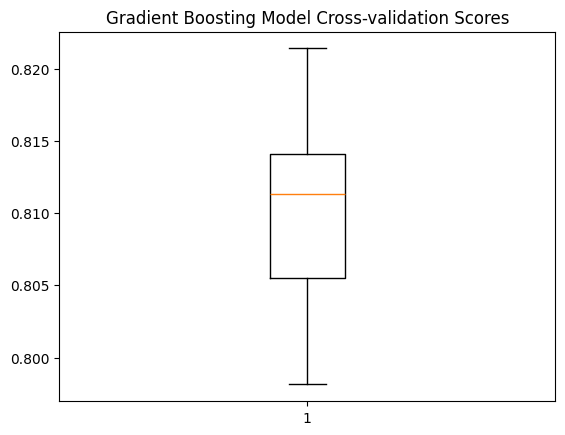

In [20]:
# Perform cross-validation
best_clf = grid_search.best_estimator_
scores3 = cross_val_score(best_clf, x_train2, y_train2, cv=5)

# Mean accuracy scores
print("Accuracy: %0.4f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

print()

# Box plot of scores
plt.boxplot(scores3)
plt.title('Gradient Boosting Model Cross-validation Scores')
plt.show()

In [21]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 100}


In [22]:
print(grid_search.best_score_)

0.8100880203333002


#### Best Parameters and Prediction

In [23]:
# Finding the best parameters from fine-tuning
best_params = grid_search.best_params_

# Initialize a new instance of the model with the best parameters
best_model = GradientBoostingClassifier(**best_params)

# Fit the model to the training data
best_model.fit(x_train2, y_train2)

# Make predictions on the test data
y_test_pred = best_model.predict(x_test2)

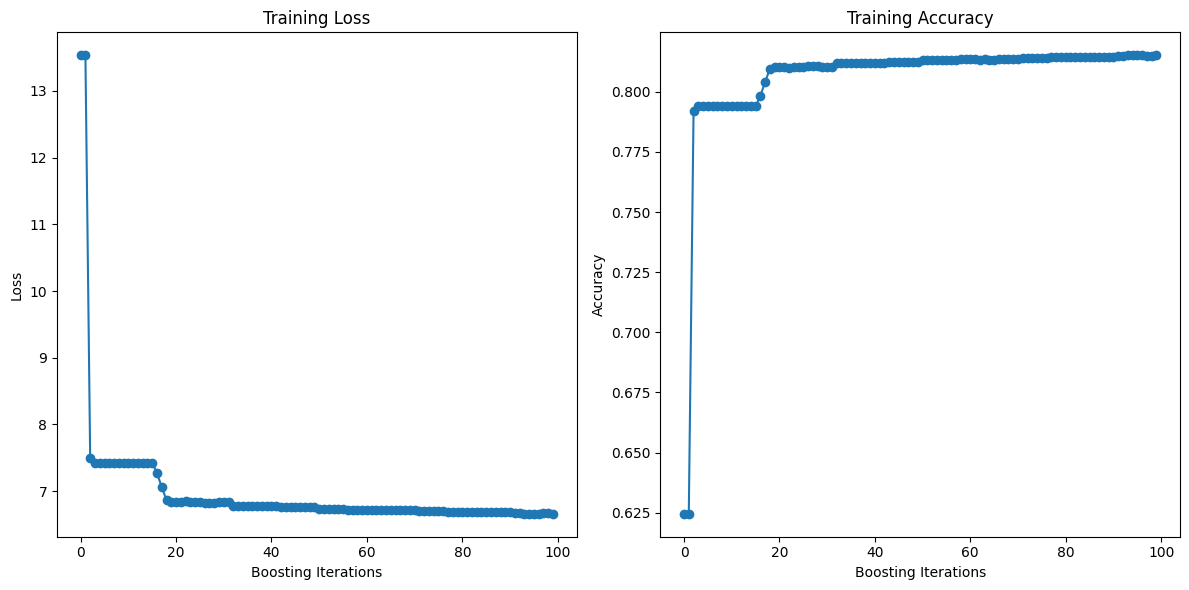

In [24]:
from sklearn.metrics import log_loss

# Initialize lists to store the loss and accuracy at each stage
train_loss = []
train_acc = []

# For each stage of the training
for y_pred in best_model.staged_predict(x_train2):
    # Calculate the loss and accuracy
    loss = log_loss(y_train2, y_pred)
    acc = accuracy_score(y_train2, y_pred)

    # Add the loss and accuracy to the lists
    train_loss.append(loss)
    train_acc.append(acc)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'o-')
plt.title('Training Loss')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

# Plot the training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'o-')
plt.title('Training Accuracy')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#### Feature Importance

Surpisingly, Model 2 had feature 99 as an important predictive feature which when I looked into broke down to geographic location. I do not know why.

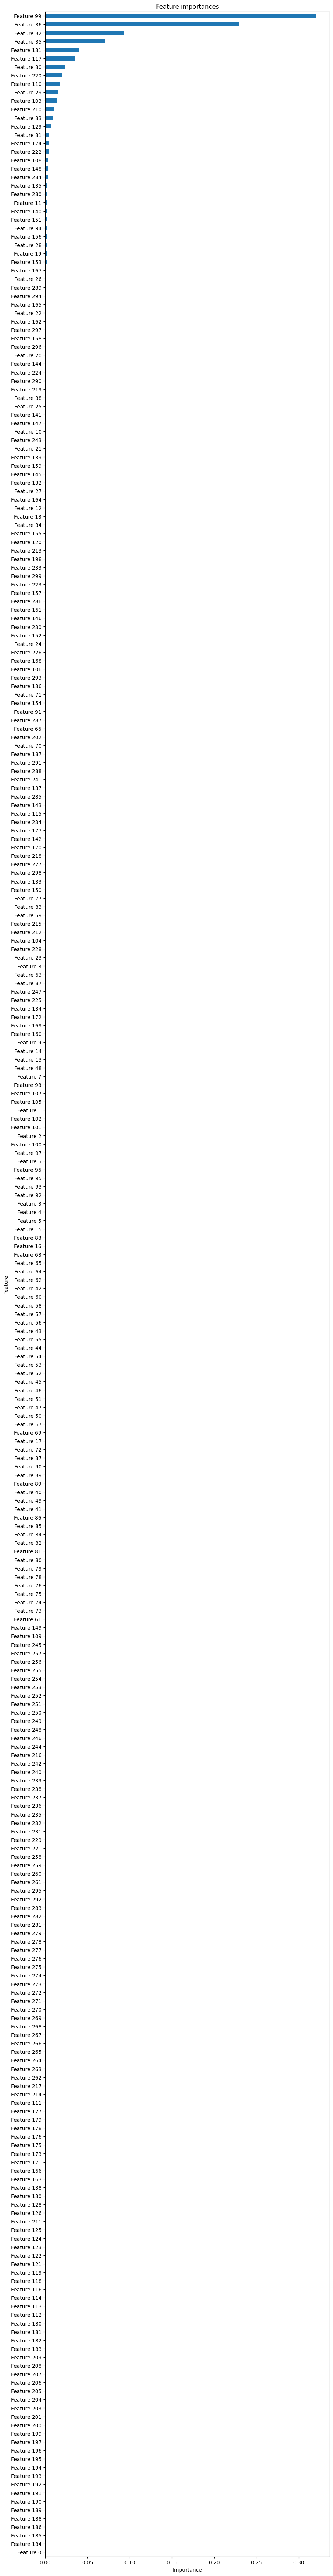

In [25]:
# Get feature names
feature_names = ["Feature " + str(i) for i in range(x_train2.shape[1])]

# Create a pandas Series with feature importances
importances = pd.Series(best_model.feature_importances_, index=feature_names)

# Sort the importances
sorted_importances = importances.sort_values()

# Create a horizontal bar plot
plt.figure(figsize=(10, 0.3 * len(feature_names)))
sorted_importances.plot(kind='barh')
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##### "Feature 99"

In [26]:
# Feature 99 is between these columns
f = sdf.iloc[:, 97:101]
f

,patient_state_IN,patient_state_KS,patient_state_KY,patient_state_LA
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
12901,0.0,0.0,0.0,0.0
12902,0.0,0.0,0.0,0.0
12903,0.0,0.0,0.0,0.0
12904,0.0,0.0,0.0,0.0


#### Evaluation Metrics

In [ ]:
# Calculate Accuracy, Precision, Recall, and F1 Score for the training set
accuracy = accuracy_score(y_train2, y_test_pred) # suppose to be y_test not y_train2
precision = precision_score(y_train2, y_test_pred)
recall = recall_score(y_train2, y_test_pred)
f1 = f1_score(y_train2, y_test_pred)

df_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

# Display table of eval metrics
display(HTML(tabulate.tabulate(df_metrics, tablefmt='html', headers='keys')))

#### Optuna

*Optuna supports Python 3.7 or newer. I was unable to fine-tune with it. See documentation.*

*Optuna Documentation: https://optuna.readthedocs.io/en/stable/installation.html*

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1.0, 0.1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    clf = GradientBoostingClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        subsample=subsample, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, 
        max_depth=max_depth, 
        max_features=max_features, 
        random_state=42
    )

    return cross_val_score(clf, x_train2, y_train2, cv=5, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

### Apply ML to the challenge test set

*Submission file of cancer diagnosis predictions*

In [31]:
# Save the 'submission' DataFrame to a CSV file
submission["DiagPeriodL90D"] = y_test_pred
submission.to_csv('submission2.csv',index=False)

In [33]:
submission.head()

,patient_id,DiagPeriodL90D
0,573710,1
1,593679,1
2,184532,1
3,447383,1
4,687972,1


In [34]:
submission

,patient_id,DiagPeriodL90D
0,573710,1
1,593679,1
2,184532,1
3,447383,1
4,687972,1
...,...,...
5787,977076,1
5788,922960,1
5789,759690,1
5790,911717,0


In [35]:
sub = submission['DiagPeriodL90D'].value_counts()
print(sub)

DiagPeriodL90D
1    4430
0    1362
Name: count, dtype: int64


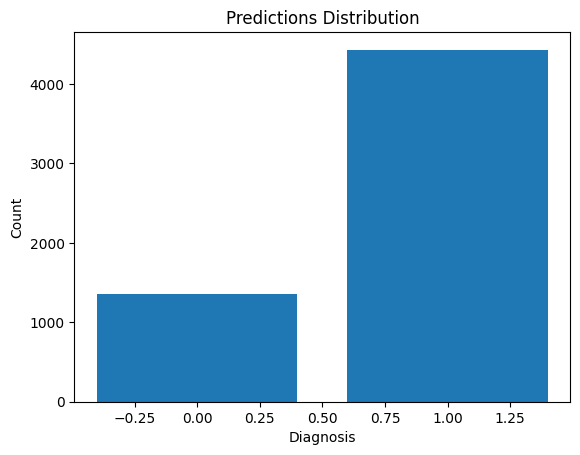

In [36]:
plt.bar(sub.index, sub.values)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Predictions Distribution')
# plt.savefig('target-variable.png', dpi=300) # Save Image
plt.show()